In [1]:
### Settings

haloID      = 1
box         = "/HydroSims/Magneticum/Box4/uhr_test"


### Packages

using Printf
using LinearAlgebra
using JLD
using QuadGK
using Statistics
using PyCall
using PyPlot
using LaTeXStrings
using GadgetIO
using GadgetUnits
using GadgetGalaxies
using Unitful
using UnitfulAstro
using Missings
using HypothesisTests
using Distributions
using CSV
using DataFrames
using Cosmology
using Suppressor


# Functions

# Tranform Cartesian vector into [r,θ,ϕ] Spherical vector
function cartesian_to_spherical(x)
    s = zeros(3)
    s[1]    = norm(x) # Radius
    s[2]    = acosd(x[3] / s[1])# * 180 / π # θ[°]
    s[3]    = acosd(x[1] / sqrt(x[1]*x[1] + x[2]*x[2]))# * 180 / π # ϕ[°]
    return s
end

# Rotation Matrix to align x with reference vector
function aligner(x, ref=[0,0,1])
    x       = x ./ norm(x)
    ref     = ref ./ norm(ref)
    vx      = x × ref
    cx      = transpose(x) * ref
    Vx      = [0 -vx[3] vx[2]; vx[3] 0 -vx[1]; -vx[2] vx[1] 0]
    aligner = I + Vx + (Vx * Vx ./ (1+cx))
    return aligner
end

function orbit_J(subID, centID, pathtofile) # Find central sub maybe using SUBFIND -> centID = FSUB[GRNR[subID+1]+1]
    # Read subhalo features
    head        = read_header(pathtofile)
    smst        = convert_units_physical(read_subfind(pathtofile, "SMST"), :mass, head)
    spos        = convert_units_physical(read_subfind(pathtofile, "SPOS"), :pos, head)
    svel        = read_subfind(pathtofile, "SVEL") # no conversion since already physical units??
    # Return with masses added
    return ((spos[:,subID+1] .- spos[:,centID+1]) × (svel[:,subID+1] .- svel[:,centID+1])) .* (smst[1,subID+1]+smst[2,subID+1]+smst[5,subID+1])
end

orbit_J (generic function with 1 method)

In [2]:
# Read and correct orbital spins for stellar part only

halo_story  = load("/home/moon/sfortune/spinevo/halostories/halo_$haloID.jld", "halo_story")

for i in 1:length(halo_story["SNAP"])
    if !ismissing(halo_story["J_orbital"][1,i])
        #print("$(norm(halo_story["J_orbital"][:,i]))")
        path_to_file    = "$box/groups_$(@sprintf("%03i", halo_story["SNAP"][i]))/sub_$(@sprintf("%03i", halo_story["SNAP"][i]))"
        head            = read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][i]))/sub_$(@sprintf("%03i", halo_story["SNAP"][i]))")
        loop_smst       = convert_units_physical(read_subfind(path_to_file, "SMST"), :mass, head)
        halo_story["J_orbital"][:,i]    ./= ( (loop_smst[1,halo_story["I_SUB"][i]+1] + loop_smst[2,halo_story["I_SUB"][i]+1] + loop_smst[5,halo_story["I_SUB"][i]+1]) / convert_units_physical_mass(halo_story["M_STAR_2"][i], head) )
        #new     = norm(halo_story["J_orbital"][:,i])
        #if old < new
            #println("i $i, snap $(halo_story["SNAP"][i]): $old -> $new, diff $(new-old)   ---   $(loop_smst[1,halo_story["I_SUB"][i]+1]) | $(loop_smst[2,halo_story["I_SUB"][i]+1]) | $(loop_smst[5,halo_story["I_SUB"][i]+1])")
        #end
    end
end



# Calculations
merger_data = Dict(
    "J_main"        => Array{Float64}(undef, 3, 0), 
    "J_main_abs"    => Array{Float64}(undef, 0), 
    "j_main_abs"    => Array{Float64}(undef, 0), 
    "j_main"        => Array{Float64}(undef, 3, 0), 
    "J_orbits"      => Array{Float64}(undef, 3, 0), 
    "J_sum"         => Array{Float64}(undef, 3, 0), 
    "J_sum_abs"     => Array{Float64}(undef, 0), 
    "J_int_sum"     => Array{Float64}(undef, 3, 0), 
    "J_int_sum_abs" => Array{Float64}(undef, 0), 
    "ANG_neighbors" => Array{Float64}(undef, 0), 
    "ANG_main"      => Array{Float64}(undef, 0), 
    "δJ_main"       => Array{Float64}(undef, 3, 0), 
    "δJ_main_abs"   => Array{Float64}(undef, 0), 
    "δj_main"       => Array{Float64}(undef, 3, 0), 
    "N_MERGERS"     => Array{Int64}(undef, 0),
    "M_MERGERS"     => Array{Float64}(undef, 0),
    "M_felix"       => Array{Float64}(undef, 0), 
    "M2_felix"      => Array{Float64}(undef, 0), 
    "M_fromJ"       => Array{Float64}(undef, 0), 
    "REDSHIFT"      => Array{Float64}(undef, 0),
    "SNAP"          => Array{Int64}(undef, 0),
    "ADDED_MERGERS" => Array{Int64}(undef, 0),
    "MISSING_MERGERS" => Array{Int64}(undef, 0),
    "LOOKBACKTIME"  => Array{Float64}(undef, 0),
    "I_FILE"        => haloID, 
    "I_SUB"         => Array{Int64}(undef, 0) )


head    = read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][1]))/sub_$(@sprintf("%03i", halo_story["SNAP"][1]))")
merger_data["J_main"]       = hcat( merger_data["J_main"],          halo_story["J_STARS"][:,1] )
merger_data["j_main"]       = hcat( merger_data["j_main"],          halo_story["j_STARS"][:,1] )
merger_data["J_main_abs"]   = vcat( merger_data["J_main_abs"],      norm(halo_story["J_STARS"][:,1]) )
merger_data["j_main_abs"]   = vcat( merger_data["j_main_abs"],      norm(halo_story["j_STARS"][:,1]) )
merger_data["M_felix"]      = vcat( merger_data["M_felix"],         convert_units_physical_mass(halo_story["M_STARS"][1], head) )
merger_data["M2_felix"]     = vcat( merger_data["M2_felix"],        convert_units_physical_mass(halo_story["M_STAR_2"][1], head) )
merger_data["M_fromJ"]      = vcat( merger_data["M_fromJ"],         norm(halo_story["J_STARS"][:,1]) / norm(halo_story["j_STARS"][:,1]) )
merger_data["LOOKBACKTIME"] = vcat( merger_data["LOOKBACKTIME"],    ustrip(lookback_time(cosmology(h=head.h0, OmegaM=head.omega_0), head.z)) )
merger_data["REDSHIFT"]     = vcat( merger_data["REDSHIFT"],        halo_story["REDSHIFT"][1] )
merger_data["I_SUB"]        = vcat( merger_data["I_SUB"],           halo_story["I_SUB"][1] )
merger_data["SNAP"]         = vcat( merger_data["SNAP"],            halo_story["SNAP"][1] )

limit_loop      = length(halo_story["I_SUB"])
loop_nmergers   = 0
loop_mmergers   = 0.
loop_J_sum      = zeros(3)
loop_J_int_sum  = zeros(3)
mass_missed     = 0.
mass_added      = 0.
for i in 2:limit_loop
    print("$i ")
    if !ismissing(halo_story["J_STARS"][1,i])   # most massive
        # Check out the previous merger history
        merger_data["N_MERGERS"]    = vcat( merger_data["N_MERGERS"],       loop_nmergers )
        merger_data["M_MERGERS"]    = vcat( merger_data["M_MERGERS"],       loop_mmergers )
        merger_data["J_sum"]        = hcat( merger_data["J_sum"],           loop_J_sum )
        merger_data["J_sum_abs"]    = vcat( merger_data["J_sum_abs"],       norm(loop_J_sum) )
        merger_data["J_int_sum"]    = hcat( merger_data["J_int_sum"],       loop_J_int_sum )
        merger_data["J_int_sum_abs"]= vcat( merger_data["J_int_sum_abs"],   norm(loop_J_int_sum) )
        # Append Central halo Info
        head    = read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][i]))/sub_$(@sprintf("%03i", halo_story["SNAP"][i]))")
        merger_data["J_main"]       = hcat( merger_data["J_main"],          halo_story["J_STARS"][:,i] )
        merger_data["j_main"]       = hcat( merger_data["j_main"],          halo_story["j_STARS"][:,i] )
        merger_data["J_main_abs"]   = vcat( merger_data["J_main_abs"],      norm(halo_story["J_STARS"][:,i]) )
        merger_data["j_main_abs"]   = vcat( merger_data["j_main_abs"],      norm(halo_story["j_STARS"][:,i]) )
        merger_data["M_felix"]      = vcat( merger_data["M_felix"],         convert_units_physical_mass(halo_story["M_STARS"][i], head) )
        merger_data["M2_felix"]     = vcat( merger_data["M2_felix"],        convert_units_physical_mass(halo_story["M_STAR_2"][i], head) )
        merger_data["M_fromJ"]      = vcat( merger_data["M_fromJ"],         norm(halo_story["J_STARS"][:,i]) / norm(halo_story["j_STARS"][:,i]) )
        merger_data["LOOKBACKTIME"] = vcat( merger_data["LOOKBACKTIME"],    ustrip(lookback_time(cosmology(h=head.h0, OmegaM=head.omega_0), head.z)) )
        merger_data["REDSHIFT"]     = vcat( merger_data["REDSHIFT"],        halo_story["REDSHIFT"][i] )
        merger_data["I_SUB"]        = vcat( merger_data["I_SUB"],           halo_story["I_SUB"][i] )
        merger_data["SNAP"]         = vcat( merger_data["SNAP"],            halo_story["SNAP"][i] )
        # Reset merger values
        loop_J_sum      = zeros(3)
        loop_J_int_sum  = zeros(3)
        loop_nmergers   = 0
        loop_mmergers   = 0.
    elseif !ismissing(halo_story["J_orbital"][1,i]) # existing neighbor
        loop_nmergers  += 1
        loop_mmergers  += convert_units_physical_mass(halo_story["M_STAR_2"][i], head)
        loop_J_sum     += halo_story["J_orbital"][:,i]

        head    = read_header("$box/groups_$(@sprintf("%03i", halo_story["SNAP"][i]))/sub_$(@sprintf("%03i", halo_story["SNAP"][i]))")
        try
            snapshot    = Snapshot(box, halo_story["SNAP"][i])
            snapshot.snapbase
            snapshot.subbase
            g           = Galaxy(snapshot, halo_story["I_SUB"][i])
            @suppress begin
                read_halo!(g, units=:physical, props=((:stars, ["POS", "VEL", "MASS"]),))
            end
            halo_story["J_STARS"][:,i]  = angular_momentum(g.stars)#, sph_small)
            halo_story["j_STARS"][:,i]  = specific_angular_momentum(g.stars)#, sph_small)
            loop_J_int_sum += halo_story["J_STARS"][:,i]  
            merger_data["ADDED_MERGERS"]    = vcat( merger_data["ADDED_MERGERS"], i)
            mass_added  += convert_units_physical_mass(halo_story["M_STAR_2"][i], head)
        catch e
            print(" ")
            print(e)
            print(" ")
            merger_data["MISSING_MERGERS"]  = vcat( merger_data["MISSING_MERGERS"], i)
            mass_missed += convert_units_physical_mass(halo_story["M_STAR_2"][i], head)
        end
    elseif halo_story["SNAP"][i-1] < halo_story["SNAP"][i] || !ismissing(halo_story["J_STARS"][1,i]) || !ismissing(halo_story["J_STARS"][2,i]) || !ismissing(halo_story["J_STARS"][3,i])
        println("Problem with line $i")
    end
end
# Final Check out of previous merger history
merger_data["N_MERGERS"]    = vcat( merger_data["N_MERGERS"],       loop_nmergers )
merger_data["M_MERGERS"]    = vcat( merger_data["M_MERGERS"],       loop_mmergers )
merger_data["J_sum"]        = hcat( merger_data["J_sum"],           loop_J_sum )
merger_data["J_sum_abs"]    = vcat( merger_data["J_sum_abs"],       norm(loop_J_sum) )
merger_data["J_int_sum"]    = hcat( merger_data["J_int_sum"],       loop_J_int_sum )
merger_data["J_int_sum_abs"]= vcat( merger_data["J_int_sum_abs"],   norm(loop_J_int_sum) )

# Calculate changes
for i in 1:length(merger_data["SNAP"])-1
    if norm(merger_data["J_sum"][:,i+1]) > 0
        merger_data["ANG_neighbors"]    = vcat( merger_data["ANG_neighbors"],
            acosd((transpose(merger_data["J_main"][:,i+1])*merger_data["J_sum"][:,i+1]) / (norm(merger_data["J_main"][:,i+1])*norm(merger_data["J_sum"][:,i+1]))) )
    else
        merger_data["ANG_neighbors"]    = vcat( merger_data["ANG_neighbors"], 0. )
    end
    merger_data["ANG_main"] = vcat( merger_data["ANG_main"],
        acosd((transpose(merger_data["J_main"][:,i])*merger_data["J_main"][:,i+1]) / (norm(merger_data["J_main"][:,i])*norm(merger_data["J_main"][:,i+1]))) )
    merger_data["δJ_main"]  = hcat( merger_data["δJ_main"],
        merger_data["J_main"][:,i] .- merger_data["J_main"][:,i+1] )
    merger_data["δj_main"]  = hcat( merger_data["δj_main"],
        merger_data["j_main"][:,i] .- merger_data["j_main"][:,i+1] )
    merger_data["δJ_main_abs"]  = vcat( merger_data["δJ_main_abs"],
        norm(merger_data["J_main"][:,i] .- merger_data["J_main"][:,i+1]) )
end

println("\n\nNow witness the firepower of this fully armed and operational battle station!\n")
println("$(size(merger_data["N_MERGERS"]))   ---   $(size(merger_data["J_sum"]))   ---   $(size(merger_data["J_main"]))   ---   $(size(merger_data["j_main"]))")
println("$(size(merger_data["MISSING_MERGERS"]))   ---   $(size(merger_data["ADDED_MERGERS"]))")
println("Missed Mass = $mass_missed   ---  Considered Mass = $mass_added")

2 3  ErrorException("File /HydroSims/Magneticum/Box4/uhr_test/snapdir_135/snap_135.0 not present!") 4  ErrorException("File /HydroSims/Magneticum/Box4/uhr_test/snapdir_135/snap_135.0 not present!") 5  ErrorException("File /HydroSims/Magneticum/Box4/uhr_test/snapdir_135/snap_135.0 not present!") 6  ErrorException("File /HydroSims/Magneticum/Box4/uhr_test/snapdir_135/snap_135.0 not present!") 7  ErrorException("File /HydroSims/Magneticum/Box4/uhr_test/snapdir_135/snap_135.0 not present!") 8  ErrorException("File /HydroSims/Magneticum/Box4/uhr_test/snapdir_135/snap_135.0 not present!") 9  ErrorException("File /HydroSims/Magneticum/Box4/uhr_test/snapdir_135/snap_135.0 not present!") 10  ErrorException("File /HydroSims/Magneticum/Box4/uhr_test/snapdir_135/snap_135.0 not present!") 11  ErrorException("File /HydroSims/Magneticum/Box4/uhr_test/snapdir_135/snap_135.0 not present!") 12  ErrorException("File /HydroSims/Magneticum/Box4/uhr_test/snapdir_135/snap_135.0 not present!") 13  ErrorExcept

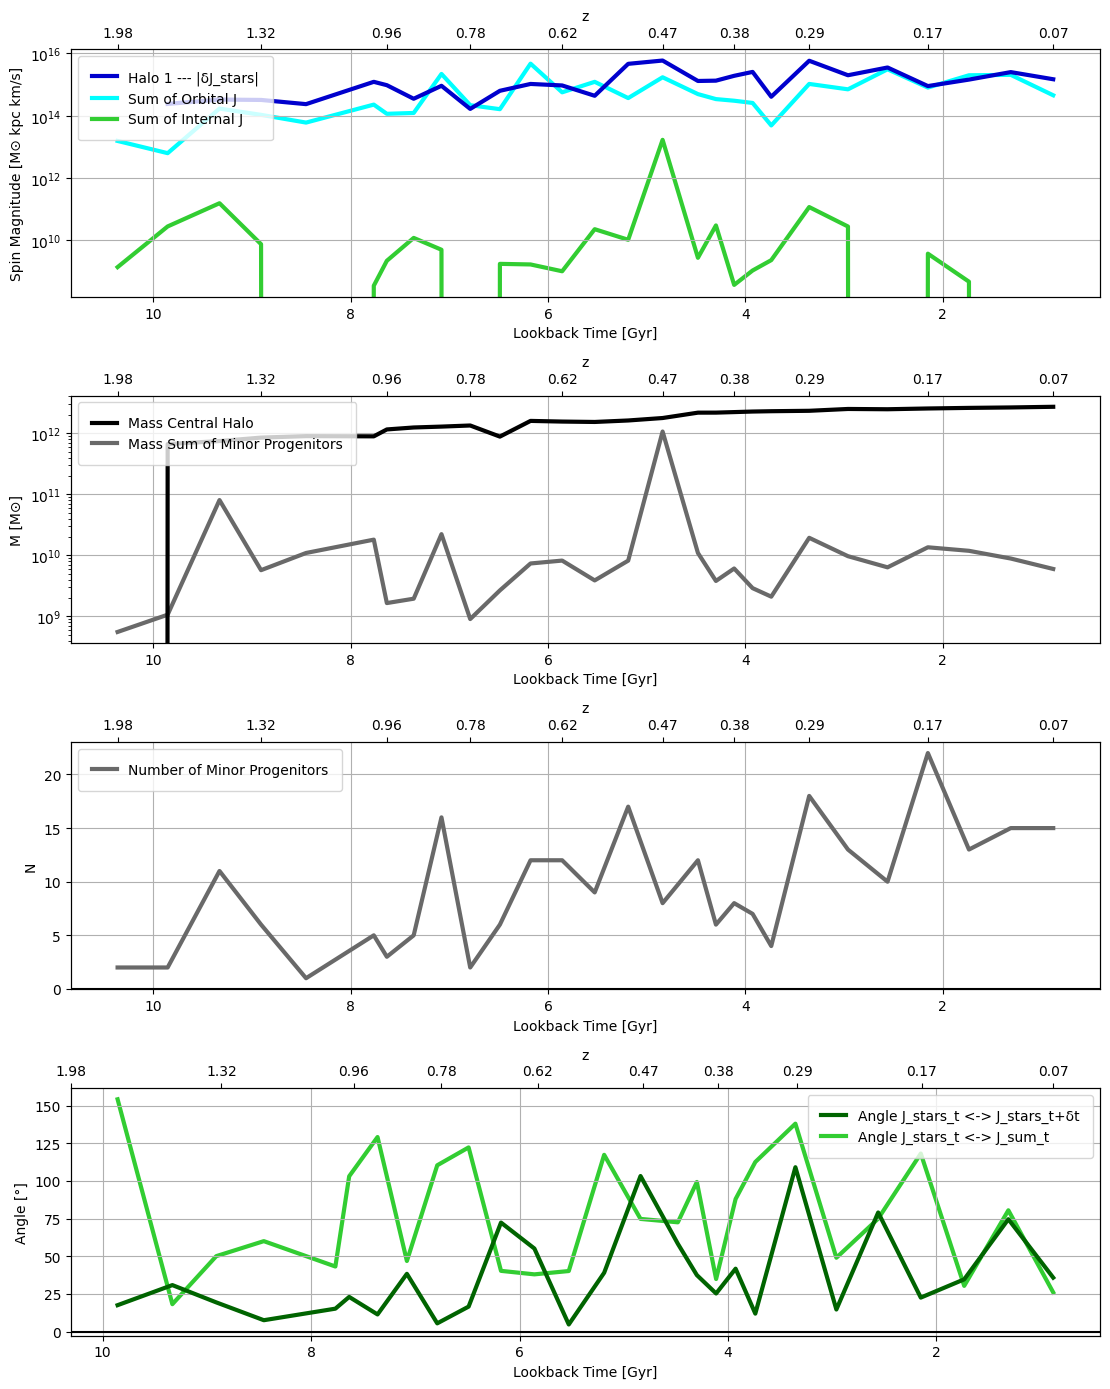

In [3]:
### Figure
N_plots = 4
z_2dec  = round.(merger_data["REDSHIFT"],digits=2) 
fig, ax = subplots(N_plots)


ax[1].plot(merger_data["LOOKBACKTIME"][1:end-1], merger_data["δJ_main_abs"], 
        "-", color="mediumblue", lw=3, label="Halo $haloID --- |δJ_stars|", alpha=1, zorder=3)
ax[1].plot(merger_data["LOOKBACKTIME"], merger_data["J_sum_abs"], 
        "-", color="cyan", lw=3, label="Sum of Orbital J", alpha=1, zorder=1)
ax[1].plot(merger_data["LOOKBACKTIME"], merger_data["J_int_sum_abs"], 
        "-", color="limegreen", lw=3, label="Sum of Internal J", alpha=1, zorder=1)
ax[1].set_xlabel("Lookback Time [Gyr]")
ax[1].invert_xaxis()
ax[1].set_ylabel("Spin Magnitude [M⊙ kpc km/s]")
ax[1].set_yscale("log")
ax[1].grid()
ax[1].axhline(color="black")
ax[1].legend(loc="upper left", frameon=true, borderpad=1, handlelength=1.8)
ax2 = ax[1].twiny()
ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(merger_data["LOOKBACKTIME"][1:3:end])
ax2.set_xticklabels(z_2dec[1:3:end])
ax2.set_xlabel("z")


ax[2].plot(merger_data["LOOKBACKTIME"], merger_data["M2_felix"], 
        "-", color="black", lw=3, label="Mass Central Halo", alpha=1, zorder=4)
ax[2].plot(merger_data["LOOKBACKTIME"], merger_data["M_MERGERS"], 
        "-", color="dimgrey", lw=3, label="Mass Sum of Minor Progenitors", alpha=1, zorder=3)
ax[2].set_xlabel("Lookback Time [Gyr]")
ax[2].invert_xaxis()
ax[2].set_ylabel("M [M⊙]")
ax[2].set_yscale("log")
ax[2].grid()
ax[2].axhline(color="black")
ax[2].legend(loc="upper left", frameon=true, borderpad=1, handlelength=1.8)
ax2 = ax[2].twiny()
ax2.set_xlim(ax[2].get_xlim())
ax2.set_xticks(merger_data["LOOKBACKTIME"][1:3:end])
ax2.set_xticklabels(z_2dec[1:3:end])
ax2.set_xlabel("z")


ax[3].plot(merger_data["LOOKBACKTIME"], merger_data["N_MERGERS"], 
        "-", color="dimgrey", lw=3, label="Number of Minor Progenitors", alpha=1, zorder=3)
ax[3].set_xlabel("Lookback Time [Gyr]")
ax[3].invert_xaxis()
ax[3].set_ylabel("N")
ax[3].grid()
ax[3].axhline(color="black")
ax[3].legend(loc="upper left", frameon=true, borderpad=1, handlelength=1.8)
ax2 = ax[3].twiny()
ax2.set_xlim(ax[3].get_xlim())
ax2.set_xticks(merger_data["LOOKBACKTIME"][1:3:end])
ax2.set_xticklabels(z_2dec[1:3:end])
ax2.set_xlabel("z")


ax[4].plot(merger_data["LOOKBACKTIME"][1:end-1], merger_data["ANG_main"], 
        "-", color="darkgreen", lw=3, label="Angle J_stars_t <-> J_stars_t+δt", alpha=1, zorder=3)
ax[4].plot(merger_data["LOOKBACKTIME"][1:end-1], merger_data["ANG_neighbors"], 
        "-", color="limegreen", lw=3, label="Angle J_stars_t <-> J_sum_t", alpha=1, zorder=1)
ax[4].set_xlabel("Lookback Time [Gyr]")
ax[4].invert_xaxis()
ax[4].set_ylabel("Angle [°]")
ax[4].grid()
ax[4].axhline(color="black")
ax[4].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax2 = ax[4].twiny()
ax2.set_xlim(ax[4].get_xlim())
ax2.set_xticks(merger_data["LOOKBACKTIME"][1:3:end])
ax2.set_xticklabels(z_2dec[1:3:end])
ax2.set_xlabel("z")


scale=0.7
fig.set_size_inches(16scale, 5*N_plots*scale)
fig.tight_layout()


#fig.savefig(joinpath(@__DIR__, "plots/halo_$(haloID)_graphs.png"), bbox_inches="tight", pad_inches=.1)